In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daigt-external-dataset/daigt_external_dataset.csv
/kaggle/input/argugpt/argugpt.csv
/kaggle/input/argugpt/machine-dev.csv
/kaggle/input/argugpt/machine-test.csv
/kaggle/input/argugpt/machine-train.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_03.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_02.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv
/kaggle/input/daigt-proper-train-dataset/train_drcat_01.csv
/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


In [2]:
!pip install -q keras_nlp==0.6.3 keras-core==0.1.7

In [3]:
import os
os.environ["KERAS_BACKEND"] = "jax" #jax or tensorflow or torch
import keras_nlp
import keras_core as keras
import keras_core.backend as K

import torch
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap =mpl.cm.get_cmap('coolwarm')


2024-02-12 16:53:33.571238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-12 16:53:33.571330: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-12 16:53:33.744949: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using JAX backend.


/tmp/ipykernel_34/155040086.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap =mpl.cm.get_cmap('coolwarm')


In [4]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasNLP:", keras_nlp.__version__)

TensorFlow: 2.15.0
Keras: 0.1.7
KerasNLP: 0.6.3


In [ ]:
Configuration
class CFG:
        verbose = 0
        wandb = True
        competition = 'llm-detect-ai-generated-text'
        _wandb_kernel = 'awsaf49'
        comment ='DebertaV3-MaxSeq_200-ext_s-torch'
        
        preset = 'deberta_v3_base_en'
        sequence_length =200
        device ='TPU'
        seed = 42
        num_folds = 5
        selected_folds = [0,1]
        epochs = 3
        batch_size =3
        drop_remainder  = True
        cache = True
        scheduler = 'cosine'
        class_names =["real", "fake"]
        num_classes = len(class_names)
        class_labels=  list(range(num_classes))
        label2name = dict(zip(class_labels, class_names))
        name2label = {v:k for k, v in label2name.items()}

In [6]:
#Set for reproducibility
keras.utils.set_random_seed(CFG.seed)

In [7]:
def get_device():
    "Detect and intializes GPU/TPU automatically"
    try:
        tpu = tf.distribute.cluster_resolver.TFConfigClusterResolver() # create a cluster resolver object for TPUs
        #init a distribution strategy
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy =tf.distribute.TPUStrategy(tpu)
        print(f'> Running on TPU', tpu.master(), end='|')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device = CFG.device
    except: #if TPU not available
        gpus = tf.config.list_logical_devices("GPU")
        ngpu = len(gpus)
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device

In [8]:
strategy, CFG.device = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on GPU | Num of GPUs:  2


In [9]:
Base_path ='/kaggle/input/llm-detect-ai-generated-text'

# Train Data: 1,378
# Sample:


,id,prompt_id,text,generated,label,name
0,0059830c,0,Cars. Cars have been around since they became ...,0,0,real
1,005db917,0,Transportation is a large necessity in most co...,0,0,real


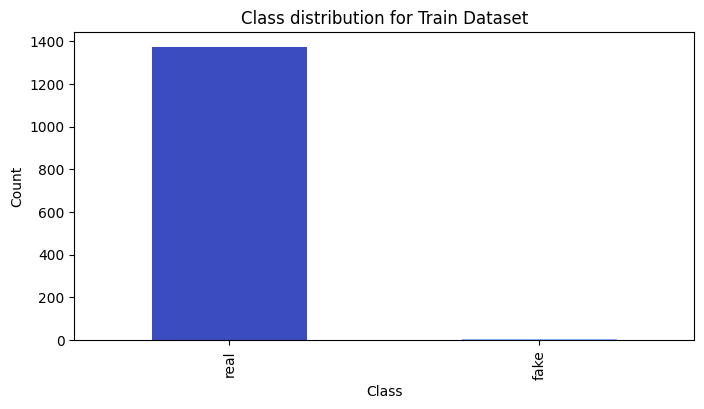

In [10]:
df = pd.read_csv(f'{Base_path}/train_essays.csv')
df['label'] =df.generated.copy()
df['name'] = df.generated.map(CFG.label2name)


print("# Train Data: {:,}".format(len(df)))
print("# Sample:")
display(df.head(2))

plt.figure(figsize=(8,4))
df.name.value_counts().plot.bar(color =[cmap(0.0),cmap(0.25), cmap(0.9), cmap(1.0)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution for Train Dataset")
plt.show()

# External Data: 28,210
# Sample:


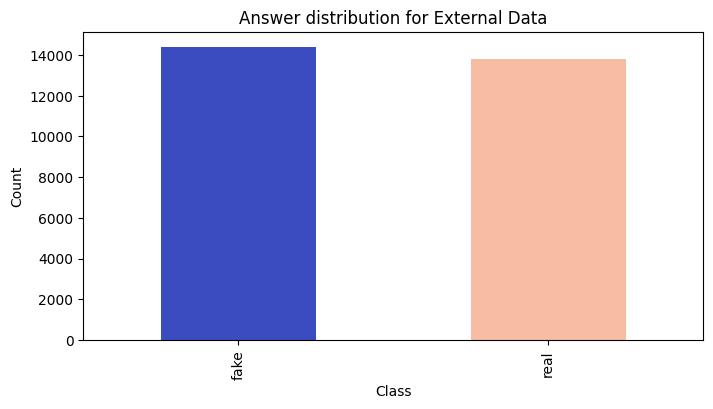

In [11]:
#External Datasets with (1) Proper Train Dataset (2) ArguGPT
ext_df1 = pd.read_csv('/kaggle/input/daigt-proper-train-dataset/train_drcat_04.csv')
ext_df2 = pd.read_csv('/kaggle/input/argugpt/argugpt.csv')[['id','text','model']]
ext_df2.rename(columns = {'model':'source'},inplace = True)
ext_df2['label'] =1

ext_df = pd.concat([
    ext_df1[ext_df1.source =='persuade_corpus'].sample(10000),
    ext_df1[ext_df1.source != 'persuade_corpus'],
])

ext_df['name'] = ext_df.label.map(CFG.label2name)
print("# External Data: {:,}".format(len(ext_df)))
print("# Sample:")
ext_df.head(2)

plt.figure(figsize=(8,4))
ext_df.name.value_counts().plot.bar(color = [cmap(0.0),cmap(0.65)])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Answer distribution for External Data")
plt.show()


In [12]:
df = ext_df.copy().reset_index(drop = True)
df.head()

,essay_id,text,label,source,prompt,fold,name
0,83BB96F966DB,Students would benefit from being able to atte...,0,persuade_corpus,NaN,2,real
1,80D6E256AA49,Landform or alien? The face on Mars looks pret...,0,persuade_corpus,NaN,2,real
2,4A028F63CFCA,The human body is a complex network of muscles...,0,persuade_corpus,NaN,7,real
3,5782F64504B9,Summer projects are a means by which schools a...,0,persuade_corpus,NaN,9,real
4,97DD2D770B03,"Dear Mr. Senator,\n\nI have decided to express...",0,persuade_corpus,NaN,6,real


In [13]:
#Data Split
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits = CFG.num_folds, shuffle= True, random_state=CFG.seed)
df = df.reset_index(drop = True)
df['stratify'] = df.label.astype(str) + df.source.astype(str)
df['fold'] = -1
for fold, (train_index, val_index) in enumerate(skf.split(df, df['stratify'])):
    df.loc[val_index, 'fold'] = fold
df.groupby(["fold", "name", "source"]).size()

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


fold  name  source           
0     fake  chat_gpt_moth         484
            darragh_claude_v6     200
            darragh_claude_v7     200
            falcon_180b_v1        211
            llama2_chat           484
                                 ... 
4     fake  radek_500             100
            train_essays            1
      real  original_moth         484
            persuade_corpus      2000
            train_essays          275
Length: 63, dtype: int64

In [14]:
#Tokenization
preprocessor =keras_nlp.models.DebertaV3Preprocessor.from_preset(
    preset = CFG.preset, 
    sequence_length = CFG.sequence_length,)

2464616/2464616 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step       


In [15]:
inp = preprocessor(df.text.iloc[0]) #-> Process text for the first row
for k, v in inp.items():
    print(k, ":", v.shape)

token_ids : (200,)
padding_mask : (200,)


In [16]:
def preprocess_fn(text, label=None):
    text =  preprocessor(text)
    return(text, label) if label is not None else text

In [17]:
#DataLoader
def build_dataset(texts, labels = None, batch_size= 32, cache =False, drop_remainder= True, repeat= False, shuffle =1024):
    AUTO = tf.data.AUTOTUNE
    slices = (texts,)if labels is None else( texts, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.cache()if cache else ds
    ds = ds.map(preprocess_fn, num_parallel_calls = AUTO)
    ds = ds.repeat() if repeat else ds
    opt = tf.data.Options()
    if shuffle:
        ds =  ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
    ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder = drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

In [18]:
#Fetch Dataset
def get_datasets(fold):
    train_df = df[df.fold!= fold].sample(frac =1)
    train_texts = train_df.text.tolist()
    train_labels = train_df.label.tolist()
    train_ds = build_dataset(train_texts, train_labels, 
                            batch_size =CFG.batch_size * CFG.replicas, cache = CFG.cache,
                            shuffle = True, drop_remainder = True, repeat  =True)
    valid_df = df[df.fold ==fold].sample(frac =1)
    valid_texts = valid_df.text.tolist()
    valid_labels = valid_df.label.tolist()
    
    valid_ds = build_dataset(valid_texts, valid_labels,
                            batch_size = min(CFG.batch_size * CFG.replicas, len(valid_df)),cache = CFG.cache,
                            shuffle = False, drop_remainder = True, repeat  =False)
    
    return(train_ds, train_df), (valid_ds, valid_df)
    

In [19]:
import wandb

try: 
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key = api_key)
    annonymous = None
except:
    anonymous = 'must'
    wandb.login(anonymous = anonymous, relogin = True)

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [20]:
# Initializes the W&B run with a config file and W&B run settings.
def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}  # Create config dictionary
    config.update({"fold": int(fold)})  # Add fold to config
    run = wandb.init(project="llm-fake-text",
                     name=f"fold-{fold}|max_seq-{CFG.sequence_length}|model-{CFG.preset}",
                     config=config,
                     group=CFG.comment,
                     save_code=True)
    return run

# Log best result for error analysis
def log_wandb():
    wandb.log({'best_auc': best_auc, 'best_loss': best_loss, 'best_epoch': best_epoch})

# Fetch W&B callbacks
def get_wb_callbacks(fold):
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_metr]  # Return WandB callbacks

In [21]:
#Learning Rate Setup
import math

def get_lr_callback(batch_size = 8, mode ='cos', epochs =10, plot=False):
    lr_start, lr_max, lr_min = 0.6e-6, 0.5e-6*batch_size, 0.3e-6
    lr_ramp_ep, lr_sus_ep, lr_decay = 1,0, 0.75
    
    def lrfn(epoch): #how to update lr
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start)/lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode =='exp' :lr = (lr_max -lr_min) * lr_decay ** (epoch -lr_ramp_ep -lr_sus_ep) + lr_min
        elif mode =='step' :lr = lr_max * lr_decay **((epoch - lr_ramp_ep - lr_sus_ep)//2)
        elif mode =='cos': 
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 *(1+math.cos(phase)) + lr_min
        return lr

    if plot:
        plt.figure(figsize =(10,5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()
        
    return keras.callbacks.LearningRateScheduler(lrfn, verbose =False) 

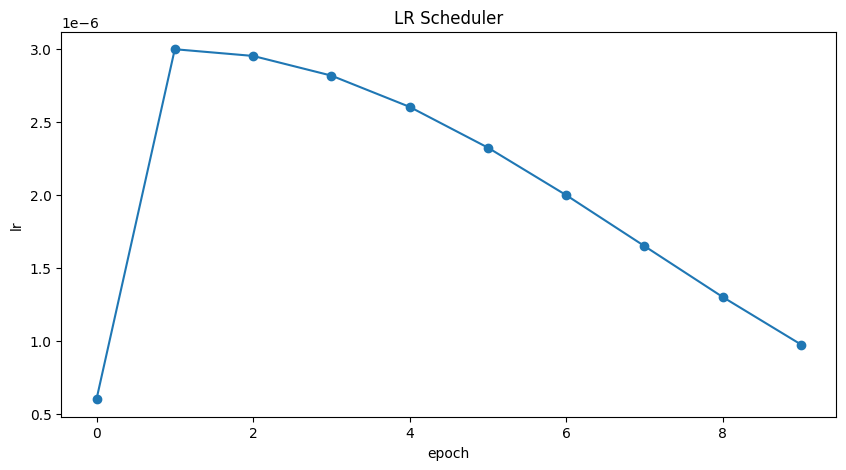

In [22]:
_=get_lr_callback(CFG.batch_size * CFG.replicas, plot = True)

In [23]:
#Get Training Callback
def get_callbacks(fold): 
    callbacks = []
    lr_cb = get_lr_callback(CFG.batch_size*CFG.replicas)
    ckpt_cb = keras.callbacks.ModelCheckpoint(f'fold{fold}.keras',
                                             monitor = 'val_auc',
                                             save_best_only =True,
                                             save_weights_only=False,
                                             mode= 'max')
    callbacks.extend([lr_cb,ckpt_cb])
    
    if CFG.wandb:
        wb_cbs = get_wb_callbacks(fold)
        callbacks.extend(wb_cbs)
        
    return callbacks

In [24]:
#Modeling
def build_model():
    classifier = keras_nlp.models.DebertaV3Classifier.from_preset(
     CFG.preset,
    preprocessor =None,
    num_classes =1)
    inputs = classifier.input
    logits = classifier(inputs)
    
    outputs = keras.layers.Activation("sigmoid")(logits)
    model = keras.Model(inputs, outputs)
    
    #compile
    model.compile(
    optimizer = keras.optimizers.AdamW(5e-6),
    loss =keras.losses.BinaryCrossentropy(label_smoothing =0.02),
    metrics =[keras.metrics.AUC(name ="auc"),],
    jit_compile = True
    )
    
    return model
    
    
    

In [25]:
#call the model
model = build_model()

735557816/735557816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃ Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask        │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ token_ids           │ (None, None)      │       0 │ -                    │
│ (InputLayer)        │                   │         │                      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ deberta_v3_classif… │ (None, 1)         │ 184,42… │ padding_mask[0][0],  │
│ (DebertaV3Classifi… │                   │         │ token_ids[0][0]      │
├─────────────────────┼───────────────────┼─────────┼──────────────────────┤
│ activation          │ (None, 1)         │       0 │ deberta_v3_classifi… │
│ (Activation)        │                   │         │                      │
└─────────────────────┴───────────────────┴─────────┴──────────────────────┘

 Total params: 184,422,913 (703.52 MB)

 Trainable params: 184,422,913 (703.52 MB)

 Non-trainable params: 0 (0.00 B)

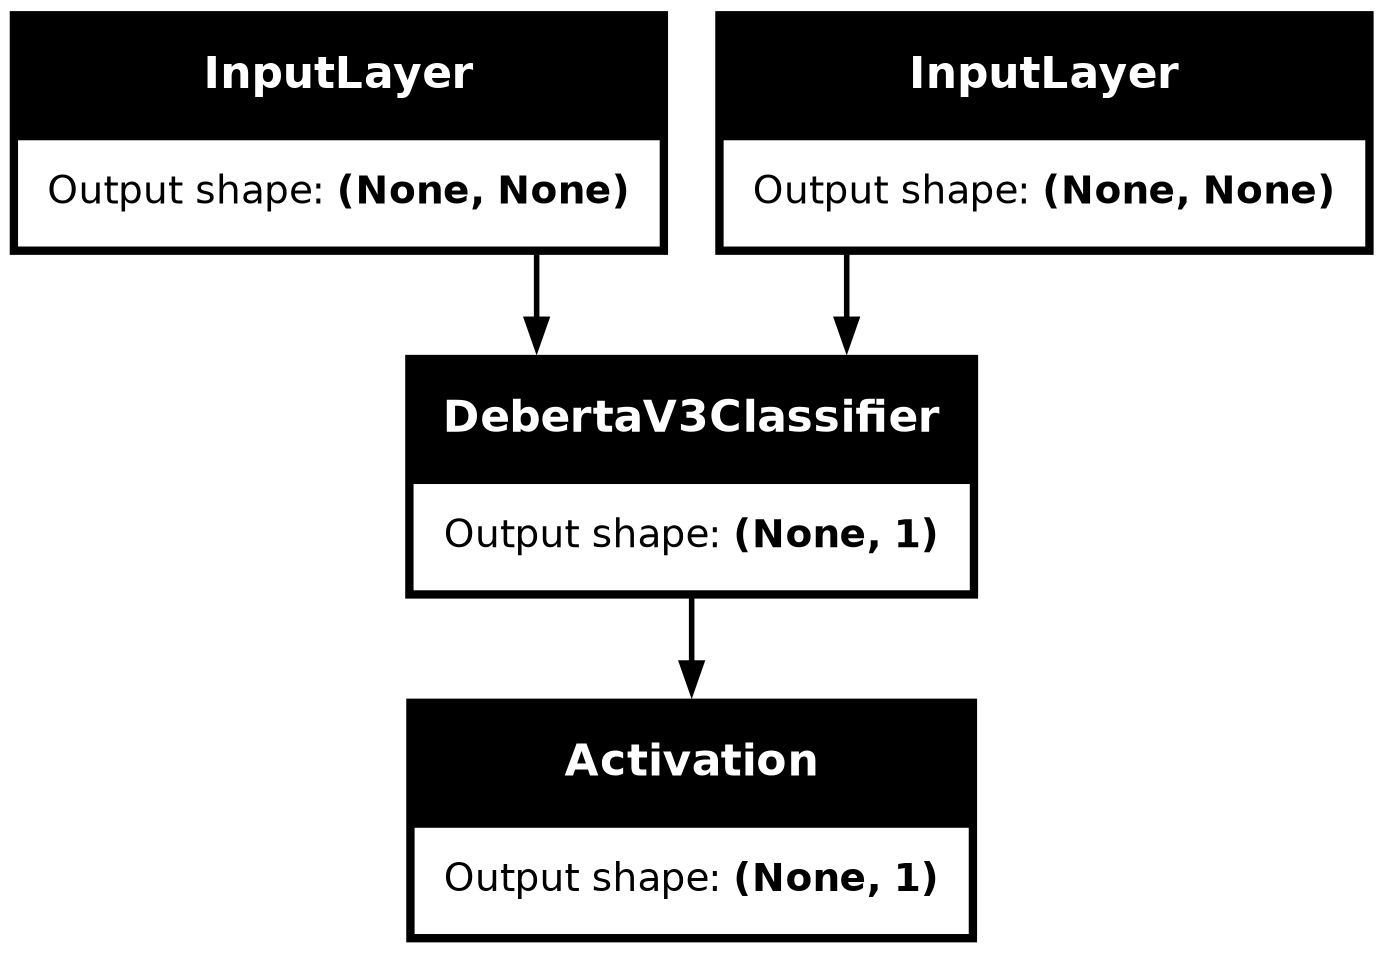

In [27]:
keras.utils.plot_model(model, show_shapes=True)

In [28]:
#Training
for fold in CFG.selected_folds:
    if CFG.wandb:
        run = wandb_init(fold)
    #Get  training dataset
    (train_ds, train_df),(valid_ds, valid_df) = get_datasets(fold)
    #Get callback while training
    callbacks = get_callbacks(fold)
    
    #Print training information
    print('#'* 50)
    print(f'Fold:{fold+1}| Model:{CFG.preset}\n\ BatchSize:{CFG.batch_size* CFG.replicas}| Scheduler:{CFG.scheduler}')
    print(f'Num Train: {len(train_df)}| Num Valid: {len(valid_df)}')
    print('#'* 50)
    
    #Clear the session
    K.clear_session()
    with strategy.scope():
        model=build_model()
    #start training
    history = model.fit(train_ds, 
                        validation_data =valid_ds, 
                        epochs = CFG.epochs, 
                        callbacks = callbacks, 
                        steps_per_epoch=int(len(train_df) / CFG.batch_size / CFG.replicas),)
    best_epoch = np.argmax(model.history.history['val_auc'])
    best_auc = model.history.history['val_auc'][best_epoch]
    best_loss = model.history.history['val_loss'][best_epoch]
    
    if CFG.wandb:
        log_wandb()
        wandb.run.finish()
        
    print("\n\n")
    
    

wandb: Currently logged in as: anony-mouse-662065130373848457. Use `wandb login --relogin` to force relogin


##################################################
Fold:1| Model:deberta_v3_base_en
\ BatchSize:6| Scheduler:cosine
Num Train: 22568| Num Valid: 5642
##################################################


/opt/conda/lib/python3.10/site-packages/keras_core/src/backend/jax/numpy.py:123: UserWarning: Explicitly requested dtype int64 requested in arange is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.arange(start, stop, step=step, dtype=dtype)
/opt/conda/lib/python3.10/site-packages/keras_core/src/backend/jax/core.py:58: UserWarning: Explicitly requested dtype int64 requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=dtype)


Epoch 1/3
3761/3761 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - auc: 0.9332 - loss: 0.3025

wandb: ERROR Unable to log learning rate.


3761/3761 ━━━━━━━━━━━━━━━━━━━━ 1662s 425ms/step - auc: 0.9332 - loss: 0.3024 - val_auc: 0.9946 - val_loss: 0.1387 - learning_rate: 6.0000e-07
Epoch 2/3
3761/3761 ━━━━━━━━━━━━━━━━━━━━ 1606s 427ms/step - auc: 0.9978 - loss: 0.0832 - val_auc: 0.9955 - val_loss: 0.1386 - learning_rate: 3.0000e-06
Epoch 3/3
3761/3761 ━━━━━━━━━━━━━━━━━━━━ 1604s 426ms/step - auc: 0.9989 - loss: 0.0702 - val_auc: 0.9982 - val_loss: 0.1078 - learning_rate: 2.9540e-06


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


wandb: WARNING No program path found when generating artifact job source for a non-colab notebook run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁▃█
epoch/val_loss,██▁
best_auc,0.99816
best_epoch,2


##################################################
Fold:2| Model:deberta_v3_base_en
\ BatchSize:6| Scheduler:cosine
Num Train: 22568| Num Valid: 5642
##################################################
Epoch 1/3
3761/3761 ━━━━━━━━━━━━━━━━━━━━ 1635s 428ms/step - auc: 0.9270 - loss: 0.3204 - val_auc: 0.9980 - val_loss: 0.1073 - learning_rate: 6.0000e-07
Epoch 2/3
3761/3761 ━━━━━━━━━━━━━━━━━━━━ 1594s 424ms/step - auc: 0.9971 - loss: 0.0875 - val_auc: 0.9996 - val_loss: 0.0744 - learning_rate: 3.0000e-06
Epoch 3/3
3761/3761 ━━━━━━━━━━━━━━━━━━━━ 1595s 424ms/step - auc: 0.9989 - loss: 0.0716 - val_auc: 0.9990 - val_loss: 0.0824 - learning_rate: 2.9540e-06


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.
wandb: WARNING No program path found when generating artifact job source for a non-colab notebook run. See https://docs.wandb.ai/guides/launch/create-job
wandb: WARNING Source type is set to 'artifact' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


best_auc,▁
best_epoch,▁
best_loss,▁
epoch/auc,▁▇█
epoch/epoch,▁▅█
epoch/learning_rate,▁██
epoch/loss,█▂▁
epoch/val_auc,▁█▅
epoch/val_loss,█▁▃
best_auc,0.99964
best_epoch,1


In [29]:
predictions =  model.predict(
valid_ds,
batch_size = min(CFG.batch_size * CFG.replicas*2, len(valid_df)),
verbose = 1)

940/940 ━━━━━━━━━━━━━━━━━━━━ 118s 120ms/step


In [32]:
pred_answers = (predictions >0.5).astype(int).squeeze()
true_answers = valid_df.label.values

print("#Predictions\n")
for i in range(5):
    row = valid_df.iloc[i]
    text = row.text
    pred_answer = CFG.label2name[pred_answers[i]]
    true_answer = CFG.label2name[true_answers[i]]
    print(f" ❓ Text {i+1}: \n {text[:100]} ..... {text[-100:]}\n")
    print(f" ✅ True: {true_answer}\n")
    print(f" 🤖 Predicted: {pred_answer}\n")
    print("-"* 90, "\n")

#Predictions

 ❓ Text 1: 
 In recent years, there has been a lot of discussion about the impact of video games on behavior, spe ..... ocial behavior. Retrieved from <https://www.sciencedirect.com/science/article/pii/S0193397316300151>

 ✅ True: fake

 🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

 ❓ Text 2: 
 As an eighth-grade student, I believe that completing high school earlier than the traditional age o ..... ers to consider completing high school early and take advantage of all the benefits it has to offer.

 ✅ True: fake

 🤖 Predicted: fake

------------------------------------------------------------------------------------------ 

 ❓ Text 3: 
 Seeking multiple opinions when making an important decision or looking for advice is almost always t ..... iases. The consensus of multiple independent advisors is most likely to result in the wisest choice.

 ✅ True: fake

 🤖 Predicted: fake

-----------------------------